# Bluesky-Adaptive Agents record their state and actions like detectors to Tiled

In [1]:
from tiled.client import from_uri
import importlib
import numpy as np
import matplotlib.pyplot as plt
c = from_uri("http://tld:8000")

In [2]:
def find_latest():
    keys= list(c.keys())
    for key in keys[::-1]:
        if "tell" in c[key]:
            return c[key]

## Grab A Run

In [3]:
run = find_latest()

In [4]:
run.metadata

{'start': {'agent_name': 'ActiveKMeans-staple-nearly',
           'model_params': {'algorithm': 'lloyd',
                            'copy_x': True,
                            'init': 'k-means++',
                            'max_iter': 300,
                            'n_clusters': 3,
                            'n_init': 'auto',
                            'random_state': None,
                            'tol': 0.0001,
                            'verbose': 0},
           'model_type': 'KMeans',
           'motor_names': ['wafer_x', 'wafer_y'],
           'motor_resolution': 0.1,
           'time': 1725394826.6568139,
           'uid': '707b744d-2d32-454d-b9a4-08b15d02f340'},
 'stop': None,
 'summary': {'datetime': datetime.datetime(2024, 9, 3, 20, 20, 26, 656814, tzinfo=datetime.timezone.utc),
             'duration': None,
             'plan_name': None,
             'scan_id': None,
             'stream_names': ['ask', 'report', 'tell'],
             'timestamp': 1725394826.6568

### That Run has data streams associated with being `tell`, `ask`, and `report` (being told about data, asked what to do next, and reporting status)

In [5]:
run

<Container {'ask', 'report', 'tell'}>

### We can inspect what the agent records

In [6]:
run['ask']['data']

<DatasetClient ['time', 'suggestion', 'cluster_centers', 'cache_len', 'latest_data', 'requested_batch_size', 'redundant_points_discarded', 'absolute_position_offset', 'batch_idx', 'batch_size']>

In [7]:
run['report']['data']

<DatasetClient ['time', 'cluster_centers', 'cache_len', 'latest_data']>

### And plot where the agent suggested we measure next

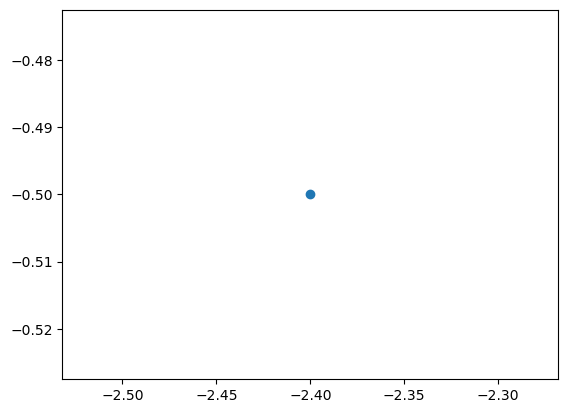

In [8]:
plt.scatter(*run['ask']['data']['suggestion'].read().T)

### The agents record data of persistent shape, so we can slice its thinking through time. E.g., only cluster centers in a clustering agent. 

In [9]:
run['ask']['data']['cluster_centers'][-1]

array([[2.29428495e-04, 2.99349636e-04, 4.75930964e-04, ...,
        6.43149468e-04, 5.35303291e-04, 4.25809463e-04],
       [1.48639132e-04, 8.87802558e-05, 6.07341604e-05, ...,
        2.69523437e-04, 2.16714379e-04, 1.62224374e-04],
       [4.43924371e-04, 3.97600406e-04, 4.29105555e-04, ...,
        2.40851640e-03, 1.89264752e-03, 1.36882128e-03]])

## That plot wasn't SUPER informative. But we can remodel everything from a report.

In [10]:
def remodel_from_report(run, idx: int = None):
        """Grabs specified (or most recent) report document and rebuilds modelling of dataset at that point.

        This enables fixed dimension reports that can be stacked and compared, while also allowing for
        deep inspection at the time of a report.

        Parameters
        ----------
        run : BlueskyRun
            Agent Run
        idx : int, optional
            Report index, by default most recent

        Returns
        -------
        model : SklearnEstimatorAgentBase
        data : dict
            Dictionary of model components, weights, independent_vars, and observables
        """
        module_ = importlib.import_module("sklearn.cluster")
        model = getattr(module_, run.metadata['start']["model_type"])().set_params(**run.metadata['start']["model_params"])
        idx = -1 if idx is None else idx
        model.cluster_centers_ = run['report']["data"]["cluster_centers"][idx]
        latest_uid = run['report']["data"]["latest_data"][idx]
        tell_idx = np.where(run['tell']["data"]["exp_uid"].read() == latest_uid)[0][-1]
        
        independents =  run['tell']["data"]["independent_variable"][:tell_idx]
        observables = run['tell']["data"]["observable"][:tell_idx]
        arr = observables

        try:
            clusters = model.predict(arr)
            distances = model.transform(arr)
        except AttributeError:
            model.fit(arr)
            model.cluster_centers_ = run['report']["data"]["cluster_centers"][idx]
            clusters = model.predict(arr)
            distances = model.transform(arr)
        return model, dict(
            clusters=clusters,
            distances=distances,
            cluster_centers=model.cluster_centers_,
            independent_vars=independents,
            observables=observables,
        )

In [11]:
model, data_dict = remodel_from_report(run)

In [12]:
data_dict.keys()

dict_keys(['clusters', 'distances', 'cluster_centers', 'independent_vars', 'observables'])

In [45]:
def make_plot(data_dict):
    independent_vars = data_dict["independent_vars"]  # This should be an array with shape (m, 2)
    clusters = data_dict["clusters"]  # This should be an array with shape (m,)
    fig = plt.figure(figsize=(8, 6))
    k = np.max(clusters)
    scatter = plt.scatter(independent_vars[:, 0], independent_vars[:, 1], c=clusters, cmap=plt.get_cmap("tab10", k+1), alpha=0.6)
    plt.colorbar(scatter, ticks=list(range(k+1)), label='Cluster')
    plt.title('2D Plot of Independent Variables by Cluster')
    plt.xlabel('Independent Var 1')
    plt.ylabel('Independent Var 2')
    return fig

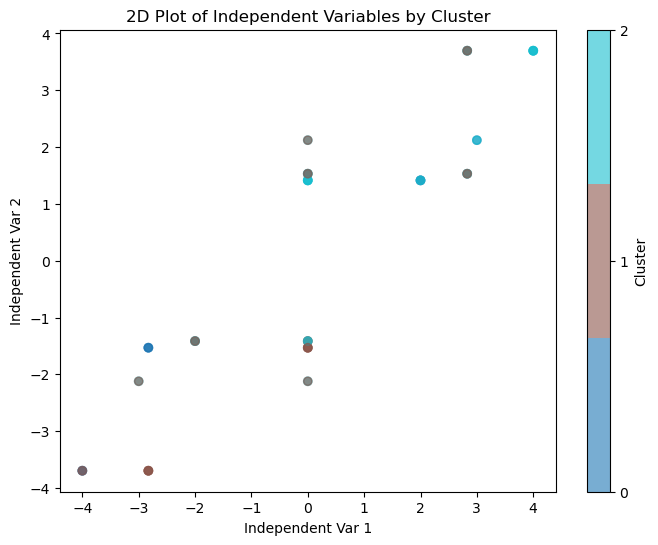

In [46]:
fig = make_plot(data_dict)